### Tree based feature selection on full datset

This is based on the following tutorial http://scikit-learn.org/stable/modules/feature_selection.html

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import DataProcess as DP
import glob
import time
import pandas as pd
from plotting_tools import plot_feature_distributions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Assemble the dataset

In [2]:
protocol_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/'
optional_datadir = '/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/'

In [3]:
allfiles = list(glob.glob(protocol_datadir+'*.dat'))+list(glob.glob(optional_datadir+'*.dat'))

all_dfs = []
for fname in allfiles:
    print(fname)
    dp = DP.dataprocess(fname,T=512,stride=512)
    all_dfs.append(dp.df)
    
feature_df = pd.concat(all_dfs)

/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject102.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject103.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject104.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject105.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject106.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject107.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject108.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Protocol/subject109.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2_data/PAMAP2_Dataset/Optional/subject101.dat
/Users/rmartinshort/Documents/Berkeley/GDSO/PAMAP2

## Train random forest and select based on feature importances

In [36]:
Y = pd.get_dummies(feature_df['activityID'],drop_first=True)
X = feature_df.drop(['activityID'],axis=1)

### Set up pipline 

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

#Scaler
Scaler = StandardScaler()

#Random forest classifier
RF = RandomForestClassifier(n_estimators=100,min_samples_split=2,min_samples_leaf=1,
                            max_depth=12,oob_score=True)

RF_balanced = RandomForestClassifier(n_estimators=100,min_samples_split=2,min_samples_leaf=1,
                            max_depth=12,oob_score=True,class_weight='balanced')

RF_balanced_subsample = RandomForestClassifier(n_estimators=100,min_samples_split=2,min_samples_leaf=1,
                            max_depth=12,oob_score=True,class_weight='balanced_subsample')
#Feature selector
FS = SelectFromModel(RF, threshold='mean',prefit=False)

In [92]:
feat_select1 = Pipeline([('scale', Scaler), ('select', FS), ('classify', RF)])
feat_select2 = Pipeline([('scale', Scaler), ('select', FS), ('classify', RF_balanced)])
feat_select3 = Pipeline([('scale', Scaler), ('select', FS), ('classify', RF_balanced_subsample)])

### Train model

In [93]:
feat_select1.fit(X_train,y_train)
feat_select1.score(X_test,y_test)

0.9574616457461645

In [94]:
feat_select2.fit(X_train,y_train)
feat_select2.score(X_test,y_test)

0.9532775453277545

In [95]:
feat_select3.fit(X_train,y_train)
feat_select3.score(X_test,y_test)

0.9518828451882845

In [82]:
print(len(RF.feature_importances_))

76


The selector has reduces the number of features to less than 100, typically 75-85 depending on which RF classifier parameters are used

### Plot feature importances

In [83]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

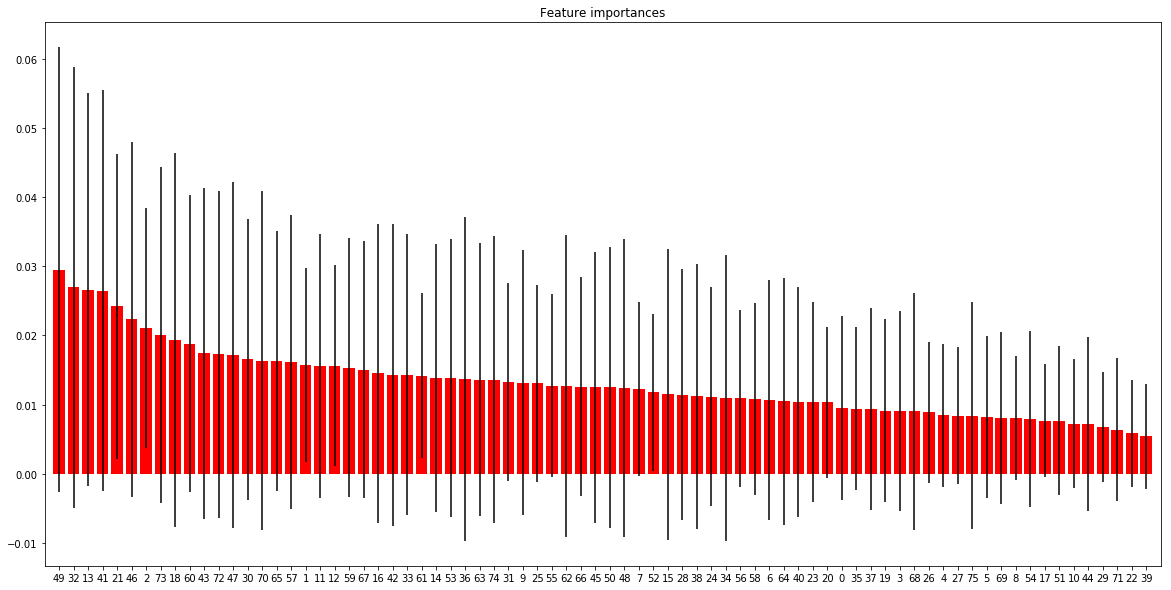

In [84]:
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), indices)
plt.xlim([-1, len(importances)])
plt.show()